In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from transformers import DistilBertTokenizerFast
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import spacy

This notebook presents a comparative analysis of traditional machine learning models and a transformer-based model for sentiment analysis in social media posts or review

We evaluated the following approaches:

- **Traditional ML models** using TF-IDF features:
  - Random Forest  
  - Multinomial Naive Bayes  
  - Logistic Regression  

- **Transformer-based model**:
  - DistilBERT

While the traditional models performed reasonably well, the **DistilBERT model significantly outperformed them**, achieving:

- ✅ **Validation Accuracy**: 98.4%  
- 📊 **F1 Score, Precision, Recall**: All ~98%

These results highlight the **superior ability of transformer models** to capture deeper semantic patterns and contextual understanding in text, compared to traditional vector-based methods.

In the following sections, you'll see:
- Data preprocessing  
- Model training and evaluation    
- Final conclusions  

In [39]:
df = pd.read_csv("/Users/tony/Documents/research_projects/uneeq_interns/Sentiment analysis/Twitter_Data.csv")

In [40]:
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [41]:
df.shape

(162980, 2)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [5]:
df['category'].value_counts()

category
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64

In [7]:
df.describe()

,category
count,162973.000000
mean,0.225436
std,0.781279
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [43]:
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [44]:
df.dropna(inplace=True)

In [45]:
df.isna().sum()

clean_text    0
category      0
dtype: int64

# preprocessing of the text

In [46]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  


In [47]:
def fast_preprocess(clean_text, batch_size=1000, n_process=4):
    cleaned = []
    docs = nlp.pipe(clean_text, batch_size=batch_size, n_process=n_process)
    for doc in docs:
        tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        cleaned.append(" ".join(tokens))
    return cleaned


In [ ]:
import pandas as pd

df = df

chunk_size = 100_000
all_cleaned = []

for i in range(0, len(df), chunk_size):
    chunk = df['clean_text'].iloc[i:i+chunk_size].tolist()
    cleaned = fast_preprocess(chunk)
    all_cleaned.extend(cleaned)
    print(f"Processed {i+chunk_size} rows")


In [29]:
df['proce_text'] = all_cleaned
df.to_csv("cleaned_text.csv",index=True)

In [51]:
dfa = pd.read_csv("/Users/tony/Documents/research_projects/uneeq_interns/Sentiment analysis/cleaned_text.csv")

In [52]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162969 entries, 0 to 162968
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
 2   proce_text  162874 non-null  object 
dtypes: float64(1), object(2)
memory usage: 3.7+ MB


In [53]:
dfa.isnull().sum()

clean_text     0
category       0
proce_text    95
dtype: int64

In [54]:
dfa.dropna(inplace=True)

In [55]:
dfa.isnull().sum()

clean_text    0
category      0
proce_text    0
dtype: int64

In [56]:
dfa.head()

,clean_text,category,proce_text
0,when modi promised “minimum government maximum...,-1.0,modi promise minimum government maximum govern...
1,talk all the nonsense and continue all the dra...,0.0,talk nonsense continue drama vote modi
2,what did just say vote for modi welcome bjp t...,1.0,vote modi welcome bjp tell rahul main campai...
3,asking his supporters prefix chowkidar their n...,1.0,ask supporter prefix chowkidar name modi great...
4,answer who among these the most powerful world...,1.0,answer powerful world leader today trump putin...


In [57]:
X = dfa['proce_text']
y = dfa['category']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [58]:
X_train.shape
X_test.shape

(32575,)

In [59]:
from sklearn.linear_model import LogisticRegression
clf = Pipeline([
    ('vectorizer_tri_grams',TfidfVectorizer()),
    ('clf',LogisticRegression(class_weight='balanced',max_iter=1000))
])

In [60]:
clf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer_tri_grams', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [61]:
y_pred = clf.predict(X_test)

In [62]:
print(accuracy_score(y_test,y_pred))

0.8155026861089792


In [68]:
print(classification_report(y_test,y_pred,target_names=["Negatives","Neutral","Positive"]))

              precision    recall  f1-score   support

   Negatives       0.74      0.79      0.76      7102
     Neutral       0.78      0.90      0.84     11025
    Positive       0.90      0.76      0.83     14448

    accuracy                           0.82     32575
   macro avg       0.81      0.82      0.81     32575
weighted avg       0.82      0.82      0.82     32575



In [92]:
clf = Pipeline([
    ('vectorizer_tri_grams',TfidfVectorizer()),
    ('naive_bayes',(MultinomialNB()))
])

In [93]:
clf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer_tri_grams', TfidfVectorizer()),
                ('naive_bayes', MultinomialNB())])

In [64]:
pred = clf.predict(X_test)

In [67]:
print(classification_report(y_test,pred,target_names=["Negative","Neutral","Positive"]))

              precision    recall  f1-score   support

    Negative       0.74      0.79      0.76      7102
     Neutral       0.78      0.90      0.84     11025
    Positive       0.90      0.76      0.83     14448

    accuracy                           0.82     32575
   macro avg       0.81      0.82      0.81     32575
weighted avg       0.82      0.82      0.82     32575



In [70]:
clf = Pipeline([
    ('vectorizer_tri_grams',TfidfVectorizer()),
    ('naive_bayes',(RandomForestClassifier()))
])

In [71]:
clf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer_tri_grams', TfidfVectorizer()),
                ('naive_bayes', RandomForestClassifier())])

In [73]:
preds = clf.predict(X_test)

In [74]:
print(classification_report(y_test,preds,target_names=["Negatives","Neutral","Positive"]))

              precision    recall  f1-score   support

   Negatives       0.85      0.54      0.66      7102
     Neutral       0.77      0.86      0.81     11025
    Positive       0.77      0.85      0.81     14448

    accuracy                           0.78     32575
   macro avg       0.80      0.75      0.76     32575
weighted avg       0.79      0.78      0.78     32575



# DistilBERT

In [9]:
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [10]:
X = df['clean_text'].tolist()
y = df['category'].tolist()

train_X,test_X,train_y,test_y = train_test_split(X,y,test_size=0.2,random_state=42)

In [11]:
from transformers import DistilBertTokenizerFast
import torch

# Initialize tokenizer
dl = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Tokenize text and convert labels to 0-based format
def tokenize_with_labels(texts, labels):
    tokenized = dl(
        texts,
        truncation=True,
        padding=True,
        max_length=128
    )
    
    tokenized['labels'] = torch.tensor([x + 1 for x in labels])
    return tokenized

train_tok = tokenize_with_labels(train_X, train_y) 
test_tok = tokenize_with_labels(test_X, test_y)

In [30]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        # Convert labels from [-1, 0, 1] to [0, 1, 2]
        self.labels = [label + 1 for label in labels]  

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}       
        item["labels"] = torch.tensor(self.labels[idx]) 
        return item

    def __len__(self):
        return len(self.labels)

# Initialize datasets with original labels (-1,0,1)
train_data = SentimentDataset(train_tok, train_y) 
test_data = SentimentDataset(test_tok, test_y)

In [31]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [32]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=3,
    problem_type="single_label_classification"
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,           
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",  
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    fp16=False,
    remove_unused_columns=False, 
    metric_for_best_model="f1",  
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics,  
)

trainer.train()
trainer.evaluate()  

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/cj/1t1x5h3j5sn8rcq_w8_21p1h0000gn/T/ipykernel_79405/78547782.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.062300,0.127693,0.966834,0.966662,0.967432,0.966834
2,0.095200,0.081154,0.980272,0.980357,0.980605,0.980272
3,0.010000,0.065218,0.985948,0.985960,0.985981,0.985948


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/cj/1t1x5h3j5sn8rcq_w8_21p1h0000gn/T/ipykernel_79405/78547782.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/cj/1t1x5h3j5sn8rcq_w8_21p1h0000gn/T/ipykernel_79405/78547782.py:10: UserWarning: To copy construct from a 

{'eval_loss': 0.06521765142679214,
 'eval_accuracy': 0.9859483340492116,
 'eval_f1': 0.9859601358019875,
 'eval_precision': 0.9859809734313069,
 'eval_recall': 0.9859483340492116,
 'eval_runtime': 118.5706,
 'eval_samples_per_second': 274.891,
 'eval_steps_per_second': 17.188,
 'epoch': 3.0}

In [33]:
predictions = trainer.predict(test_data)
preds = np.argmax(predictions.predictions, axis=1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/cj/1t1x5h3j5sn8rcq_w8_21p1h0000gn/T/ipykernel_79405/78547782.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


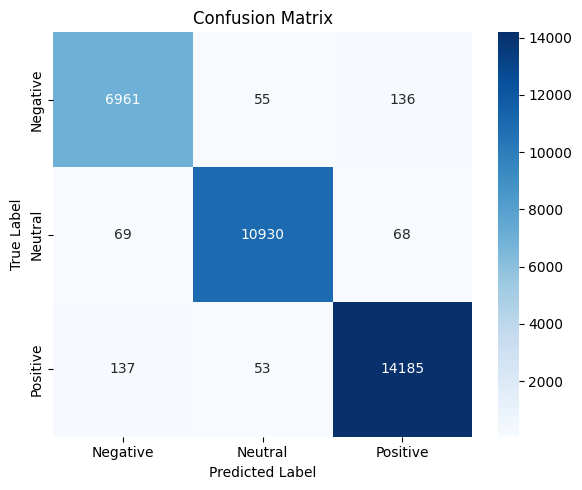

In [36]:
#confusion matrix
cm = confusion_matrix(predictions.label_ids, preds)
labels = ['Negative', 'Neutral', 'Positive']

# plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [48]:
#classification report
true_labels = predictions.label_ids
report = classification_report(
    true_labels,
    preds,
    target_names = labels,
    digits = 4
)
print(report)

              precision    recall  f1-score   support

    Negative     0.9713    0.9733    0.9723      7152
     Neutral     0.9902    0.9876    0.9889     11067
    Positive     0.9858    0.9868    0.9863     14375

    accuracy                         0.9841     32594
   macro avg     0.9824    0.9826    0.9825     32594
weighted avg     0.9841    0.9841    0.9841     32594



# Final Conclusion
In this project, I trained and evaluated multiple text classification models, including:

Traditional models: Random Forest, Multinomial Naive Bayes, and Logistic Regression with TF-IDF features
A transformer-based model: DistilBERT
While the traditional models showed decent accuracy, the DistilBERT model clearly outperformed all others, achieving:

Validation Accuracy: 98.4%
F1 Score, Precision, Recall: All around 98%
These results highlight the strength of transformer-based models in capturing deeper semantic patterns and contextual meaning in text. Compared to simpler vector-based methods, DistilBERT provided significantly better generalization and predictive performance.

In Conclusion: DistilBERT is a more effective and reliable choice for advanced text classification tasks, especially when high accuracy is important.